In [30]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns
from scipy import stats
from statannot import add_stat_annotation
from scipy.stats import mannwhitneyu
import glob, os

import warnings
warnings.filterwarnings("ignore")

In [31]:
cp_ip={'none': '#bf812d','amplified':'#35978f','deleted':'#ff9f9b'}

In [32]:
## Customizing plot
commonFontsize=8
def config_rcparams():
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = commonFontsize
    plt.rcParams['axes.labelsize'] = commonFontsize
    plt.rcParams['xtick.labelsize'] = commonFontsize
    plt.rcParams['ytick.labelsize'] = commonFontsize
    plt.rcParams['axes.titlesize'] = commonFontsize
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['ytick.color'] = 'black'
    plt.rcParams['axes.linewidth'] = 0.7
    plt.rcParams['xtick.major.width'] = 0.7
    plt.rcParams['ytick.major.width'] = 0.7
    plt.rcParams['xtick.major.size' ] = 3
    plt.rcParams['ytick.major.size' ] = 3
    plt.rcParams['text.usetex' ] = False
config_rcparams()

## Collect all the probes for the methylation

In [33]:
## listing the file name
os.chdir("data/correlation_methylation_vs_mRNA/")
methylation_tumor_corr=[]
for  i in glob.glob("*.txt"):
    methylation_tumor_corr.append(i)
os.chdir("/workspace/projects/immunoproteasome/")

In [34]:
### Importing methylation beta value
input_path2="data/"
meth_df_beta_value=pd.read_csv(input_path2+"jhu-usc.edu_PANCAN_merged_HumanMethylation27_HumanMethylation450.betaValue_whitelisted.tsv",sep="\t")
meth_df_beta_value.columns= meth_df_beta_value.columns.str.split('-').str[0:3].str.join('.')
meth_df_beta_value1=meth_df_beta_value.set_index('Composite Element REF')
meth_df_beta_value2=meth_df_beta_value1.T

In [35]:
### Importing copy number file
copy_no_df=pd.read_csv("data/all_thresholded.by_genes_whitelisted.tsv",index_col='Gene Symbol',sep="\t")
copy_no_df=copy_no_df.drop(['Locus ID','Cytoband'],axis=1)
copy_no_df.columns= copy_no_df.columns.str.split('-').str[0:3].str.join('.')
copy_no_df2=copy_no_df.T[['PSMB8','PSMB9','PSMB10','IRF1']]

In [36]:
copy_no_meth_df=pd.merge(copy_no_df2, meth_df_beta_value2, left_index=True, right_index=True)

In [37]:
## Collecting genes probe combination intersecting the probes in the methylation correaltion file with the methylation beta value file
input_path1="data/correlation_methylation_vs_mRNA/"
meth_beta_value_probe_list=list(meth_df_beta_value2.columns)
meth_probe_list=[]
frames={}
frames1={}
gene_probes=['PSMB8','PSMB9','PSMB10','IRF1']
for j in range(4):
    meth_probe_list=[]
    tissue_type=[]
    for i in range(len(methylation_tumor_corr)):
        meth_df = pd.read_csv(input_path1+methylation_tumor_corr[i],delimiter="\t")
        meth_probe_list.append(list(meth_df[meth_df['Gene']==gene_probes[j]]['Meth_Probe']))
        tissue_type.append(methylation_tumor_corr[i].split('_')[4].split('-')[0])
        
    df_tissue_probe=pd.DataFrame(meth_probe_list,columns=['probe'])
    df_tissue_probe['tumor_type']=tissue_type
    df_tissue_probe['genes']=gene_probes[j]
    frames1[j]=df_tissue_probe                

    meth_probe_list_all=list(set(sum(meth_probe_list,[])))
    all_beta_value_int_list=list(set(meth_beta_value_probe_list).intersection(meth_probe_list_all))
    
    df_probe_gene=pd.DataFrame()
    df_probe_gene['probes']=all_beta_value_int_list
    df_probe_gene['genes']=gene_probes[j]
    frames[j]=df_probe_gene

## extracting tumor type specific probe
probe_gene_df=pd.concat(frames)
df_probe_tt_genes=pd.concat(frames1)
df_probe_tt_genes_final=df_probe_tt_genes[df_probe_tt_genes['probe'].isin(list(probe_gene_df['probes']))]

In [38]:
df_probe_tt_genes_final

probe tumor_type   genes
1 17  cg12762680        GBM   PSMB9
  29  cg12762680         OV   PSMB9
2 2   cg11451801       TGCT  PSMB10
  6   cg11451801       THCA  PSMB10
  17  cg11451801        GBM  PSMB10
  22  cg11451801       KIRC  PSMB10
  29  cg11451801         OV  PSMB10
3 17  cg20287640        GBM    IRF1
  29  cg20287640         OV    IRF1

### IL6-JAK STAT pathways analysis

In [39]:
## listing the file name
os.chdir("data/r_output/")
tumor_tissue_pathway_score=[]
for  i in glob.glob("GSVA*.tsv"):
    tumor_tissue_pathway_score.append(i)

In [40]:
tt_list=list(df_probe_tt_genes_final['tumor_type'])
gene_list=list(df_probe_tt_genes_final['genes'])
probe_list=list(df_probe_tt_genes_final['probe'])

input_path11="data/r_output/"
frames_jak_stat={}
for i in range(len(tumor_tissue_pathway_score)):
    pathway_score_df=pd.read_csv(input_path11+tumor_tissue_pathway_score[i],sep='\t')
    jak_stat_pathway_score_df=pathway_score_df.T[['HALLMARK_IL6_JAK_STAT3_SIGNALING']]
    jak_stat_pathway_score_df=jak_stat_pathway_score_df.reset_index(level=0)
    frames_jak_stat[i]=jak_stat_pathway_score_df
df_jak_stat=pd.concat(frames_jak_stat)
df_jak_stat=df_jak_stat.set_index(['index'])

copy_no_meth_jak_stat_gene_df=pd.merge(copy_no_meth_df, df_jak_stat, left_index=True, right_index=True)

In [41]:
box_pairs=[(('PSMB8', 'none'),
  ('PSMB8', 'amplified')),
 (('PSMB8', 'none'),
  ('PSMB8', 'deleted')),
 (('PSMB8', 'amplified'),
  ('PSMB8', 'deleted')),
 (('PSMB9', 'none'),
  ('PSMB9', 'amplified')),
 (('PSMB9', 'none'),
  ('PSMB9', 'deleted')),
 (('PSMB9', 'amplified'),
  ('PSMB9', 'deleted')),
 (('PSMB10', 'none'),
  ('PSMB10', 'amplified')),
 (('PSMB10', 'none'),
  ('PSMB10', 'deleted')),
 (('PSMB10', 'amplified'),
  ('PSMB10', 'deleted'))]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PSMB9_amplified v.s. PSMB9_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=2.083e-01 U_stat=1.390e+06
PSMB10_none v.s. PSMB10_amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=1.277e-06 U_stat=4.800e+06
PSMB10_amplified v.s. PSMB10_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=1.387e-02 U_stat=1.866e+06
PSMB8_none v.s. PSMB8_amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=6.317e-07 U_stat=7.397e+06
PSMB8_amplified v.s. PSMB8_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=2.083e-01 U_stat=1.390e+06
PSMB9_none v.s. PSMB9_amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=6.317e-07 U_stat=7.397e+06
PSMB10_none v.s. PSMB10_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=6.075e-03 U_stat=8.527e+06
PSMB9_none v.s. PSMB9_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=5.449e-09 U_stat=5.1

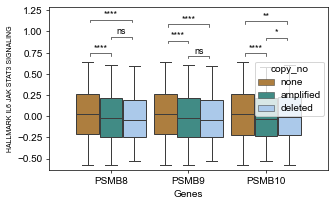

In [42]:
### plot showing IL6-JAK STAT enrichment level in sample having amplification deletion or no-alteration in PSMB8/9/10 genes
dft_PSMB8=copy_no_meth_jak_stat_gene_df[['PSMB8','HALLMARK_IL6_JAK_STAT3_SIGNALING']]
dft_PSMB8['gene']='PSMB8'
dft_PSMB8=dft_PSMB8.rename({'PSMB8': 'copy_no'}, axis=1)

dft_PSMB9=copy_no_meth_jak_stat_gene_df[['PSMB9','HALLMARK_IL6_JAK_STAT3_SIGNALING']]
dft_PSMB9['gene']='PSMB9'
dft_PSMB9=dft_PSMB9.rename({'PSMB9': 'copy_no'}, axis=1)

dft_PSMB10=copy_no_meth_jak_stat_gene_df[['PSMB10','HALLMARK_IL6_JAK_STAT3_SIGNALING']]
dft_PSMB10['gene']='PSMB10'
dft_PSMB10=dft_PSMB10.rename({'PSMB10': 'copy_no'}, axis=1)

dft_PSMB9_PSMB10=dft_PSMB9.append(dft_PSMB10)
dft_PSMB8_PSMB9_PSMB10=dft_PSMB8.append(dft_PSMB9_PSMB10)
dft_PSMB8_PSMB9_PSMB10=dft_PSMB8_PSMB9_PSMB10.dropna()

dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == 0,'copy_no'] = 'none'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == 1,'copy_no'] = 'amplified'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == 2,'copy_no'] = 'amplified'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == -1,'copy_no'] = 'deleted'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == -2,'copy_no'] = 'deleted'

plt.figure(figsize=(5,3))
res=sns.boxplot(x="gene",y="HALLMARK_IL6_JAK_STAT3_SIGNALING",hue="copy_no",data=dft_PSMB8_PSMB9_PSMB10,width=.9,linewidth=1,fliersize=.02,palette={'none': '#bf812d','amplified':'#35978f','deleted':'#a1c9f4'})
add_stat_annotation(res, data=dft_PSMB8_PSMB9_PSMB10, x="gene", y="HALLMARK_IL6_JAK_STAT3_SIGNALING",hue="copy_no",box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None, text_format='star', loc='inside', verbose=2,linewidth=0.7,fontsize = 9)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 10)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 10)
plt.setp(res.get_legend().get_texts(), fontsize='10')
plt.setp(res.get_legend().get_title(), fontsize='10')
plt.xlabel("Genes",fontsize=10)
plt.ylabel("HALLMARK IL6 JAK STAT3 SIGNALING",fontsize=7)
#plt.savefig('plots/PSMB8_9_10_JAK_STAT_plot.svg',bbox_inches = "tight",dpi=500)
plt.show()

## Interferon-alpha analysis

In [43]:
## listing the file name
os.chdir("data/r_output/")
tumor_tissue_pathway_score=[]
for  i in glob.glob("GSVA*.tsv"):
    tumor_tissue_pathway_score.append(i)

In [44]:
tt_list=list(df_probe_tt_genes_final['tumor_type'])
gene_list=list(df_probe_tt_genes_final['genes'])
probe_list=list(df_probe_tt_genes_final['probe'])

input_path11="data/r_output/"
frames_jak_stat={}
for i in range(len(tumor_tissue_pathway_score)):
    pathway_score_df=pd.read_csv(input_path11+tumor_tissue_pathway_score[i],sep='\t')
    jak_stat_pathway_score_df=pathway_score_df.T[['HALLMARK_INTERFERON_ALPHA_RESPONSE']]
    jak_stat_pathway_score_df=jak_stat_pathway_score_df.reset_index(level=0)
    frames_jak_stat[i]=jak_stat_pathway_score_df
df_jak_stat=pd.concat(frames_jak_stat)
df_jak_stat=df_jak_stat.set_index(['index'])

copy_no_meth_jak_stat_gene_df=pd.merge(copy_no_meth_df, df_jak_stat, left_index=True, right_index=True)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PSMB9_amplified v.s. PSMB9_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=3.782e-01 U_stat=1.380e+06
PSMB10_none v.s. PSMB10_amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=7.451e-07 U_stat=4.808e+06
PSMB10_amplified v.s. PSMB10_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=4.024e-02 U_stat=1.881e+06
PSMB8_none v.s. PSMB8_amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=1.332e-02 U_stat=7.143e+06
PSMB8_amplified v.s. PSMB8_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=3.782e-01 U_stat=1.380e+06
PSMB9_none v.s. PSMB9_amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=1.332e-02 U_stat=7.143e+06
PSMB10_none v.s. PSMB10_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=1.355e-03 U_stat=8.578e+06
PSMB9_none v.s. PSMB9_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=1.279e-03 U_stat=4.9

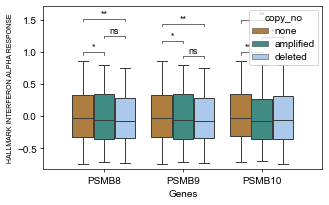

In [45]:
### plot showing interferon-alpha enrichment level in sample having amplification deletion or no-alteration in PSMB8/9/10 genes
dft_PSMB8=copy_no_meth_jak_stat_gene_df[['PSMB8','HALLMARK_INTERFERON_ALPHA_RESPONSE']]
dft_PSMB8['gene']='PSMB8'
dft_PSMB8=dft_PSMB8.rename({'PSMB8': 'copy_no'}, axis=1)

dft_PSMB9=copy_no_meth_jak_stat_gene_df[['PSMB9','HALLMARK_INTERFERON_ALPHA_RESPONSE']]
dft_PSMB9['gene']='PSMB9'
dft_PSMB9=dft_PSMB9.rename({'PSMB9': 'copy_no'}, axis=1)

dft_PSMB10=copy_no_meth_jak_stat_gene_df[['PSMB10','HALLMARK_INTERFERON_ALPHA_RESPONSE']]
dft_PSMB10['gene']='PSMB10'
dft_PSMB10=dft_PSMB10.rename({'PSMB10': 'copy_no'}, axis=1)

dft_PSMB9_PSMB10=dft_PSMB9.append(dft_PSMB10)
dft_PSMB8_PSMB9_PSMB10=dft_PSMB8.append(dft_PSMB9_PSMB10)
dft_PSMB8_PSMB9_PSMB10=dft_PSMB8_PSMB9_PSMB10.dropna()

dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == 0,'copy_no'] = 'none'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == 1,'copy_no'] = 'amplified'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == 2,'copy_no'] = 'amplified'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == -1,'copy_no'] = 'deleted'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == -2,'copy_no'] = 'deleted'

plt.figure(figsize=(5,3))
res=sns.boxplot(x="gene",y="HALLMARK_INTERFERON_ALPHA_RESPONSE",hue="copy_no",data=dft_PSMB8_PSMB9_PSMB10,width=.8,linewidth=1,fliersize=.02,palette={'none': '#bf812d','amplified':'#35978f','deleted':'#a1c9f4'})
add_stat_annotation(res, data=dft_PSMB8_PSMB9_PSMB10, x="gene", y="HALLMARK_INTERFERON_ALPHA_RESPONSE",hue="copy_no",box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None, text_format='star', loc='inside', verbose=2,linewidth=0.7,fontsize = 9)
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 10)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 10)
plt.setp(res.get_legend().get_texts(), fontsize='10')
plt.setp(res.get_legend().get_title(), fontsize='10')
plt.xlabel("Genes",fontsize=10)
plt.ylabel("HALLMARK INTERFERON ALPHA RESPONSE",fontsize=7)
#plt.savefig('plots/PSMB8_9_10_Interferon_plot.svg',bbox_inches = "tight",dpi=500)
plt.show()

### IRF1 methylation status with respect to PSMB8/9/10 Copy number

In [46]:
dft_PSMB8=copy_no_meth_df[['PSMB8','cg20287640']]
dft_PSMB8['gene']='PSMB8'
dft_PSMB8=dft_PSMB8.rename({'PSMB8': 'copy_no'}, axis=1)
dft_PSMB8=dft_PSMB8.rename({'cg20287640': 'meth_score'}, axis=1)

dft_PSMB9=copy_no_meth_df[['PSMB9','cg20287640']]
dft_PSMB9['gene']='PSMB9'
dft_PSMB9=dft_PSMB9.rename({'PSMB9': 'copy_no'}, axis=1)
dft_PSMB9=dft_PSMB9.rename({'cg20287640': 'meth_score'}, axis=1)

dft_PSMB10=copy_no_meth_df[['PSMB10','cg20287640']]
dft_PSMB10['gene']='PSMB10'
dft_PSMB10=dft_PSMB10.rename({'PSMB10': 'copy_no'}, axis=1)
dft_PSMB10=dft_PSMB10.rename({'cg20287640': 'meth_score'}, axis=1)

dft_PSMB9_PSMB10=dft_PSMB9.append(dft_PSMB10)
dft_PSMB8_PSMB9_PSMB10=dft_PSMB8.append(dft_PSMB9_PSMB10)
dft_PSMB8_PSMB9_PSMB10=dft_PSMB8_PSMB9_PSMB10.dropna()

dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == 0,'copy_no'] = 'none'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == 1,'copy_no'] = 'amplified'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == 2,'copy_no'] = 'amplified'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == -1,'copy_no'] = 'deleted'
dft_PSMB8_PSMB9_PSMB10.loc[dft_PSMB8_PSMB9_PSMB10["copy_no"] == -2,'copy_no'] = 'deleted'

In [47]:
box_pairs=[(('PSMB8', 'none'),
  ('PSMB8', 'amplified')),
 (('PSMB8', 'none'),
  ('PSMB8', 'deleted')),
 (('PSMB8', 'amplified'),
  ('PSMB8', 'deleted')),
 (('PSMB9', 'none'),
  ('PSMB9', 'amplified')),
 (('PSMB9', 'none'),
  ('PSMB9', 'deleted')),
 (('PSMB9', 'amplified'),
  ('PSMB9', 'deleted')),
 (('PSMB10', 'none'),
  ('PSMB10', 'amplified')),
 (('PSMB10', 'none'),
  ('PSMB10', 'deleted')),
 (('PSMB10', 'amplified'),
  ('PSMB10', 'deleted'))]

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PSMB9_amplified v.s. PSMB9_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=1.180e-02 U_stat=1.704e+06
PSMB10_none v.s. PSMB10_amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=5.695e-01 U_stat=5.136e+06
PSMB10_amplified v.s. PSMB10_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=3.256e-03 U_stat=2.426e+06
PSMB8_none v.s. PSMB8_amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=4.344e-01 U_stat=8.391e+06
PSMB8_amplified v.s. PSMB8_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=1.180e-02 U_stat=1.704e+06
PSMB9_none v.s. PSMB9_amplified: Mann-Whitney-Wilcoxon test two-sided, P_val=4.344e-01 U_stat=8.391e+06
PSMB10_none v.s. PSMB10_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=2.653e-04 U_stat=1.072e+07
PSMB9_none v.s. PSMB9_deleted: Mann-Whitney-Wilcoxon test two-sided, P_val=1.839e-02 U_stat=5.8

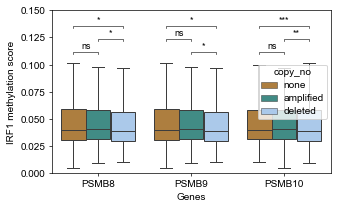

In [48]:
### plot showing IRF1 methylation status in sample having amplification deletion or no-alteration in PSMB8/9/10 genes
plt.figure(figsize=(5,3))
res=sns.boxplot(x="gene",y="meth_score",hue="copy_no",data=dft_PSMB8_PSMB9_PSMB10,showfliers=False,width=.8,linewidth=1,fliersize=.02,palette={'none': '#bf812d','amplified':'#35978f','deleted':'#a1c9f4'})
add_stat_annotation(res, data=dft_PSMB8_PSMB9_PSMB10, x="gene", y="meth_score",hue="copy_no",box_pairs=box_pairs,test='Mann-Whitney',comparisons_correction=None, text_format='star', loc='outside', verbose=2,linewidth=0.7,fontsize = 9)

res.set(ylim=(0, 0.3))
res.set_xticklabels(res.get_xmajorticklabels(), fontsize = 10)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize = 10)
plt.setp(res.get_legend().get_texts(), fontsize='10')
plt.setp(res.get_legend().get_title(), fontsize='10')
plt.xlabel("Genes",fontsize=10)
plt.ylabel("IRF1 methylation score",fontsize=10)
#plt.savefig('plots/PSMB8_9_10_meth_IRF1_plot.svg',bbox_inches = "tight",dpi=500)
plt.show()